In [1]:
import pandas as pd
import numpy as np
import math

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 10)

from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    KFold
)
import joblib
import pickle
import json

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.inspection import permutation_importance

import sys
sys.path.append('../src/features')
sys.path.append('../models')
from custom_transformers import CustomTransformer
from pipeline_builder import create_pipeline, grid_search_cv

In [2]:
df = pd.read_csv('../data/raw/data.csv')
df.head() 

,price,apartment_type,metro_station,minutes_to_metro,region,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation_type
0,6300000.0,Secondary,Опалиха,6.0,Moscow region,1.0,30.6,11.1,8.5,25.0,25,Cosmetic
1,9000000.0,Secondary,Павшино,2.0,Moscow region,1.0,49.2,20.0,10.0,6.0,15,European-style renovation
2,11090000.0,Secondary,Мякинино,14.0,Moscow region,1.0,44.7,16.2,13.1,10.0,25,Cosmetic
3,8300000.0,Secondary,Строгино,8.0,Moscow region,1.0,35.1,16.0,11.0,12.0,33,European-style renovation
4,6450000.0,Secondary,Опалиха,6.0,Moscow region,1.0,37.7,15.2,4.0,5.0,5,Without renovation


## 1. Data Exploration & Preprocessing



    price:
    
The price of the apartment in the specified currency. This is the primary target variable for prediction.

    appartment_type:
The type of apartment, such as studio, one-bedroom, two-bedroom, etc.

    metro_station:
The name of the nearest metro station to the apartment's location.

    minutes_to_metro:
The time in minutes required to walk from the apartment to the nearest metro station.

    region:
The region where the apartment is located (Moscow or Moscow Oblast).

    number_of_rooms:
The total number of rooms in the apartment, including bedrooms, living rooms, etc.

    area:
The total area of the apartment in square meters.

    living_area:
The living area of the apartment in square meters, i.e., the area usable for living.

    kitchen_area:
The area of the kitchen in square meters.

    floor:
The floor on which the apartment is located.

    number_of_floors:
The total number of floors in the building where the apartment is located.

    renovation_type:
The level of renovation of the apartment, such as "no renovation", "cosmetic renovation", "euro renovation", etc.


In [3]:
df.describe()
# No missing values here but there are some extreme ones 
# that need to be addressed

,price,minutes_to_metro,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors
count,2.267600e+04,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000
mean,3.612132e+07,11.888605,2.043129,71.966827,38.517953,12.594082,9.190466,16.556095
std,8.282561e+07,6.204457,1.523586,68.368608,38.124278,7.728074,7.549996,9.779297
min,1.150000e+06,0.000000,0.000000,6.000000,2.000000,1.000000,1.000000,1.000000
25%,7.068116e+06,7.000000,1.000000,37.400000,17.600000,8.600000,4.000000,11.000000
50%,1.134320e+07,11.000000,2.000000,53.300000,28.500000,10.600000,8.000000,16.000000
75%,2.479925e+07,15.000000,3.000000,77.140000,43.200000,14.500000,13.000000,20.000000
max,2.455020e+09,60.000000,12.000000,1117.000000,566.800000,122.000000,92.000000,97.000000


In [4]:
df.shape

(22676, 12)

In [5]:
df.dtypes

price               float64
apartment_type       object
metro_station        object
minutes_to_metro    float64
region               object
number_of_rooms     float64
area                float64
living_area         float64
kitchen_area        float64
floor               float64
number_of_floors      int64
renovation_type      object
dtype: object

In [6]:
df.minutes_to_metro = df.minutes_to_metro.astype(int)
df.number_of_rooms = df.number_of_rooms.astype(int)
df.floor = df.floor.astype(int)
df.number_of_floors = df.number_of_floors.astype(int)

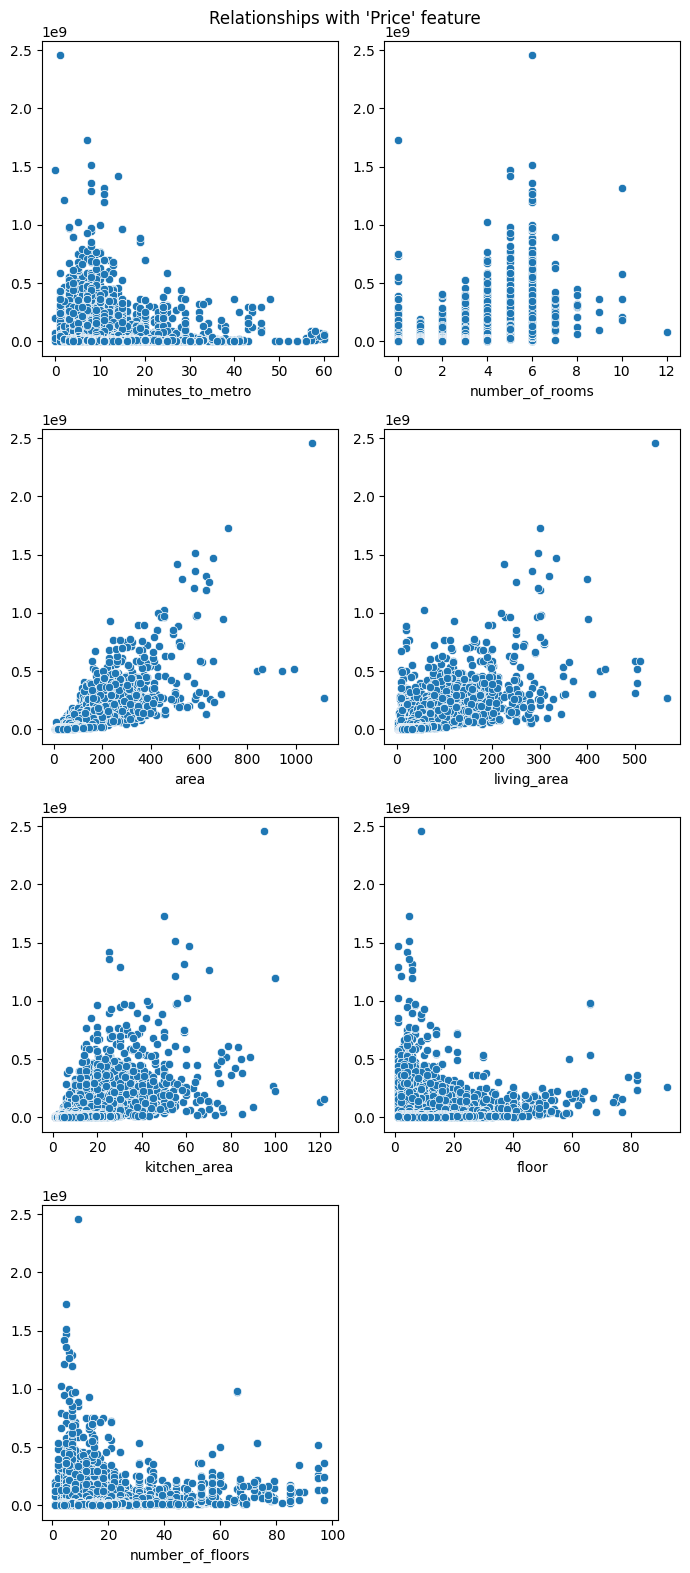

In [7]:
numerical_columns = (
    df.select_dtypes(exclude='object').drop("price", axis=1).columns
)

nrows = math.ceil(len(numerical_columns) / 2)
ncols = 2

fig, axs = plt.subplots(nrows, ncols, figsize=(7, nrows * 4))
fig.suptitle("Relationships with 'Price' feature")

axs = axs.flatten()

for i, category in enumerate(numerical_columns):
    sns.scatterplot(x=df[category], y=df["price"], ax=axs[i])
    axs[i].set_xlabel(category)
    axs[i].set_ylabel('') 

if len(numerical_columns) % 2 != 0:
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()


In [8]:
# There seem to be little to none correlation between Floor and Number of Floors
# with target varibale

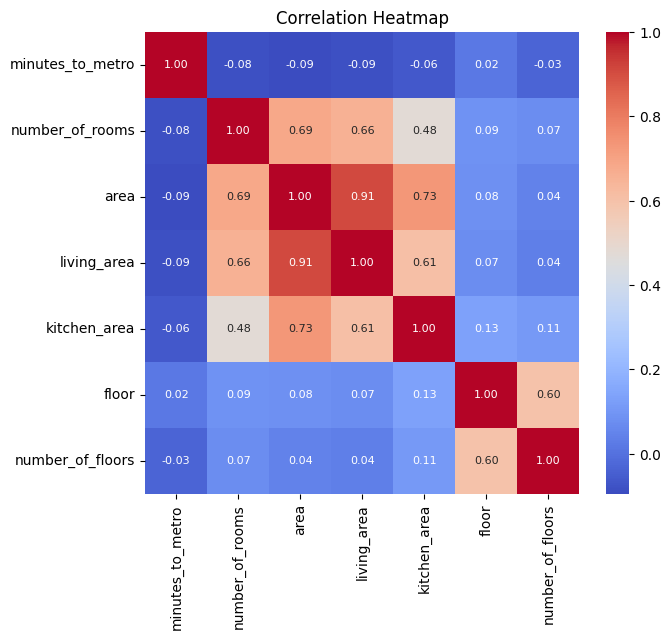

In [9]:
correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(7, 6))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f",
    annot_kws={"fontsize":8})
plt.title('Correlation Heatmap')
plt.show()

<Axes: >

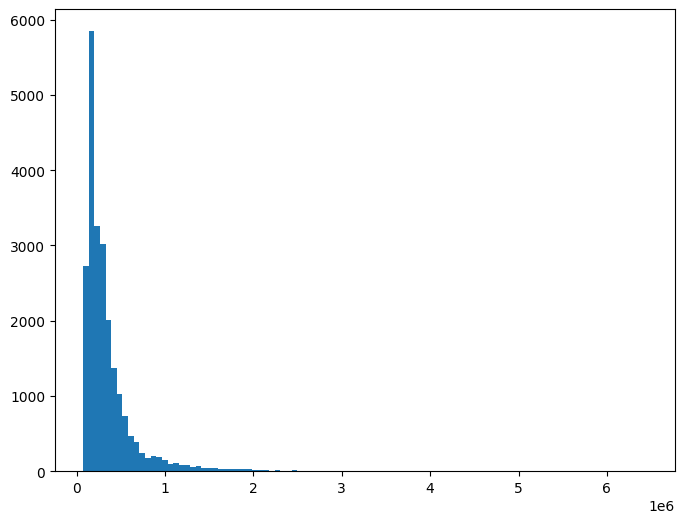

In [10]:
# Let's create a feature to see how many luxury apartments (outliers) there are
# we will kepp them for the baseline model and decide after whether to process
# them or not
df['price_per_square_meter'] = df['price']/df['area']
df['price_per_square_meter'].hist(bins=100, grid=False, figsize=(8, 6))

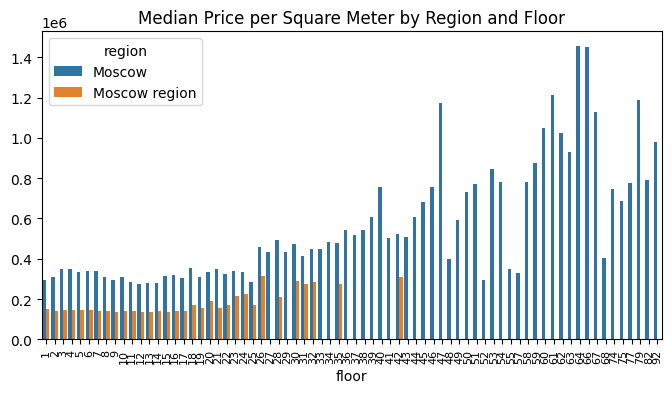

In [11]:
temp = df\
    .groupby(['region', 'floor'])\
    .agg({'price_per_square_meter': 'median'})\
    .reset_index()

temp['floor'] = temp['floor'].astype(int)

plt.figure(figsize=(8, 4))
sns.barplot(data=temp,
            x='floor', 
            y='price_per_square_meter', 
            hue='region')  
plt.ylabel("")
plt.xticks(fontsize=8, rotation=90)
plt.title('Median Price per Square Meter by Region and Floor')
plt.show()

In [12]:
# So Moscow has higher prices per square meter and taller buildings

In [13]:
# Let's create a new feature
df['is_penthouse'] = (df['floor'] == df['number_of_floors']) 

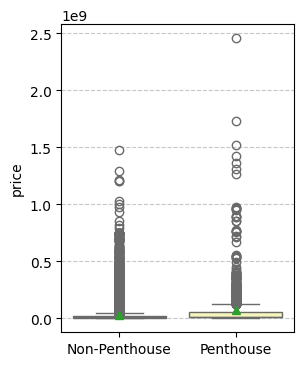

In [14]:
plt.figure(figsize=(3, 4)) 

sns.boxplot(
    x="is_penthouse",
    y='price', 
    showmeans=True,
    data=df,
    palette="Set3"
)

plt.xlabel("")  
plt.ylabel("price")  
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks([0, 1], ["Non-Penthouse", "Penthouse"])

plt.show()

In [15]:
df.sort_values('minutes_to_metro', ascending=True).head()
# All the observations with 0s in 'Minutes to metro' column isn't mistake as
# they all are located within Moscow area which is dotted with metro stations

,price,apartment_type,metro_station,minutes_to_metro,region,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation_type,price_per_square_meter,is_penthouse
5396,2.697000e+07,Secondary,Чкаловская,0,Moscow,1,41.0,13.0,20.0,8,21,Designer,6.578049e+05,False
4078,7.224072e+07,Secondary,Терехово,0,Moscow,5,144.8,78.6,33.2,6,22,Designer,4.989000e+05,False
4081,7.354392e+07,Secondary,Терехово,0,Moscow,5,144.8,78.6,33.2,8,22,Designer,5.079000e+05,False
3897,1.475430e+09,Secondary,Площадь Революции,0,Moscow,5,657.5,334.5,61.0,1,5,Designer,2.244000e+06,False
3108,7.300000e+06,Secondary,Саларьево,0,Moscow,0,28.0,19.0,5.0,4,13,European-style renovation,2.607143e+05,False


In [16]:
df['number_of_rooms'].value_counts()
# 3233 apartments with 0 rooms? Might be studios or shared ownership apartments

number_of_rooms
2     6342
1     5141
3     3814
0     3731
4     1957
5      993
6      652
7       27
8       10
10       5
9        3
12       1
Name: count, dtype: int64

In [17]:
df.describe(include='object')

,apartment_type,metro_station,region,renovation_type
count,22676,22676,22676,22676
unique,2,547,2,4
top,Secondary,Красногвардейская,Moscow,Cosmetic
freq,13152,2697,16113,12788


In [18]:
df['metro_station'].unique()

array([' Опалиха', ' Павшино', ' Мякинино', ' Строгино', ' Нахабино',
       ' Красногорская', ' Тушинская', ' Аникеевка', ' Волоколамская',
       ' Пенягино', ' Митино', ' Пятницкое шоссе', ' Чеховская',
       ' Арбатская', ' Фили', ' Белорусская', ' Кропоткинская',
       ' Спортивная', ' Алексеевская', ' Ростокино', ' Китай-город',
       ' ВДНХ', ' Динамо', ' Филатов Луг', ' Раменки', ' Минская',
       ' Аминьевская', ' Давыдково', ' Фрунзенская', ' Улица 1905 года',
       ' Кунцевская', ' Шелепиха', ' Молодёжная', ' Беговая',
       ' Бауманская', ' Славянский бульвар', ' Новокузнецкая',
       ' Парк Культуры', ' Смоленская', ' Пушкинская', ' Комсомольская',
       ' Серпуховская', ' Трубная', ' Народное Ополчение', ' Киевская',
       ' Технопарк', ' Преображенская площадь', ' Павелецкая',
       ' Красные ворота', ' Тверская', ' Петровский Парк', ' Аэропорт',
       ' Площадь Ильича', ' Краснопресненская', ' Курская',
       ' Третьяковская', ' Охотный ряд', ' Деловой центр

In [19]:
df.loc[df['renovation_type'] == 'European-style renovation', 'renovation_type']\
    = 'european'
df.loc[df['renovation_type'] == 'Without renovation', 'renovation_type']\
    = 'none'
df.loc[df['apartment_type'] == 'New building', 'apartment_type']\
    = 'newly built'
df.loc[df['apartment_type'] == 'Secondary', 'apartment_type']\
    = 'previously owned'

cols = ['metro_station', 'apartment_type', 'renovation_type', 'region']
df[cols] = df[cols].apply(lambda x: x.str.strip().str.lower())

In [20]:
df.head()

,price,apartment_type,metro_station,minutes_to_metro,region,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation_type,price_per_square_meter,is_penthouse
0,6300000.0,previously owned,опалиха,6,moscow region,1,30.6,11.1,8.5,25,25,cosmetic,205882.352941,True
1,9000000.0,previously owned,павшино,2,moscow region,1,49.2,20.0,10.0,6,15,european,182926.829268,False
2,11090000.0,previously owned,мякинино,14,moscow region,1,44.7,16.2,13.1,10,25,cosmetic,248098.434004,False
3,8300000.0,previously owned,строгино,8,moscow region,1,35.1,16.0,11.0,12,33,european,236467.236467,False
4,6450000.0,previously owned,опалиха,6,moscow region,1,37.7,15.2,4.0,5,5,none,171087.533156,True


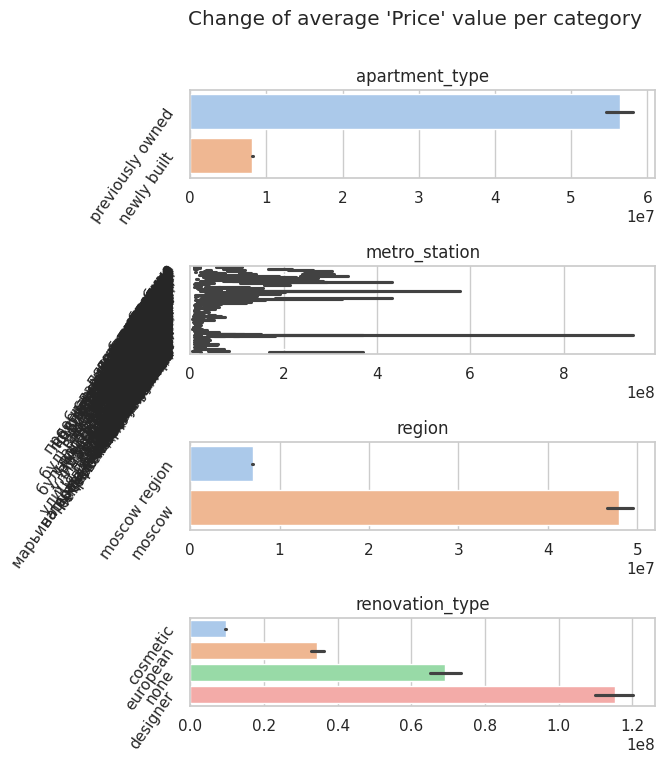

In [21]:
sns.set(style="whitegrid")

palette = sns.color_palette("pastel")

categorical_columns = df.select_dtypes(include='object').columns

nrows = len(categorical_columns)

fig, axs = plt.subplots(nrows=nrows, figsize=(6, nrows*2))
fig.suptitle("Change of average 'Price' value per category")

for i, category in enumerate(categorical_columns):
    sns.barplot(
        y=category, 
        x='price',         
        hue=category, 
        palette=palette,
        data=df, 
        ax=axs[i])
    axs[i].set_title(category)
    axs[i].set_xlabel('') 
    axs[i].set_ylabel('')
    axs[i].tick_params(axis='y', labelrotation=55)

plt.subplots_adjust(hspace=1)

plt.show()

In [22]:
# So from a category to another one mean target variable changes which means 
# these features are important

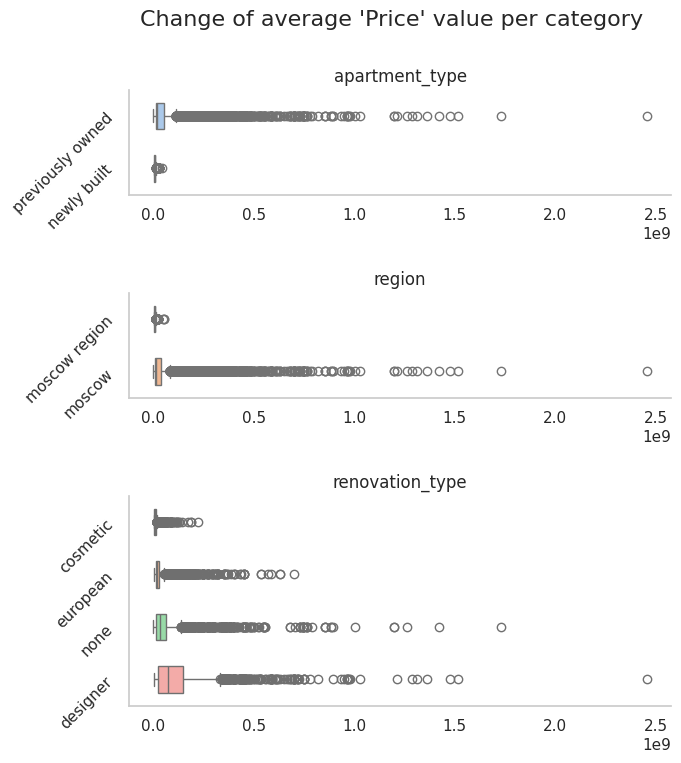

In [23]:
categorical_columns = ['apartment_type', 'region', 'renovation_type']

category_counts = df[categorical_columns].nunique()
max_count = category_counts.max()
aspect_ratios = [2 if count == max_count else 1 for count in category_counts]


fig, axs = plt.subplots(
    nrows=3, 
    figsize=(7, 8), 
    gridspec_kw={'height_ratios': aspect_ratios})

fig.suptitle("Change of average 'Price' value per category", fontsize=16)

for i, category in enumerate(categorical_columns):
    sns.boxplot(
        x='price',
        y=category,
        data=df,
        ax=axs[i],
        hue=category,
        palette=palette,
        width=0.5
    )
    sns.despine(top=True, ax=axs[i]) 
    axs[i].set_title(category, fontsize=12)
    axs[i].set_ylabel('')
    axs[i].set_xlabel("")
    axs[i].tick_params(axis='y', labelrotation=45)
    axs[i].grid(False)

plt.subplots_adjust(hspace=0.7)

plt.show()

In [24]:
# These target distribution differ from category to another one, hence we gonna 
# keep them for training

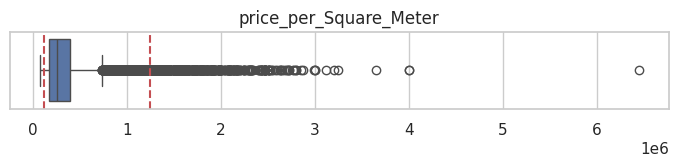

In [25]:
plt.figure(figsize=(8.5, 1)) 
sns.boxplot(data=df, x='price_per_square_meter')
plt.xlabel("")
plt.axvline(
    df['price_per_square_meter'].quantile(0.025), 
    color='r', 
    linestyle='--')
plt.axvline(
    df['price_per_square_meter'].quantile(0.975), 
    color='r', 
    linestyle='--')
plt.title('price_per_Square_Meter')
plt.show()

In [26]:
# Let's remove extremely cheap and pricey apartments as we will be focusing on
# making good prediction for common apartments

top_quantile = df['price_per_square_meter'].quantile(0.975)
low_quantile = df['price_per_square_meter'].quantile(0.025)

mask = (df['price_per_square_meter'] >= low_quantile)\
    & (df['price_per_square_meter'] <= top_quantile)

df = df[mask]
df = df.drop('price_per_square_meter', axis=1)

In [27]:
# Transform log price to assess MSLE

df["price"] = np.log1p(df['price'])
df.rename(columns={'price': 'log_price'}, inplace=True)

In [28]:
df.head()

,log_price,apartment_type,metro_station,minutes_to_metro,region,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation_type,is_penthouse
0,15.656060,previously owned,опалиха,6,moscow region,1,30.6,11.1,8.5,25,25,cosmetic,True
1,16.012735,previously owned,павшино,2,moscow region,1,49.2,20.0,10.0,6,15,european,False
2,16.221554,previously owned,мякинино,14,moscow region,1,44.7,16.2,13.1,10,25,cosmetic,False
3,15.931766,previously owned,строгино,8,moscow region,1,35.1,16.0,11.0,12,33,european,False
4,15.679591,previously owned,опалиха,6,moscow region,1,37.7,15.2,4.0,5,5,none,True


## 2. Model Training


In [29]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df.drop('log_price', axis=1),
    df['log_price'],
    test_size=0.2, 
    random_state=42
)

numerical_columns = (
    X_train_val.select_dtypes(include=np.number).columns.tolist()
)
columns_for_MTE = ['metro_station']
columns_for_OHE = ['apartment_type', 'region', 'renovation_type']

In [30]:
# Using a custom fuction to create a pipeline for our basemodel
baseline_model_pipe = create_pipeline(
    LinearRegression(), 
    columns_for_MTE, 
    columns_for_OHE,
    numerical_columns
)

kfold_split = KFold(n_splits=5, shuffle=True, random_state=0)

baseline_model = cross_validate(
    baseline_model_pipe, 
    X_train_val, 
    y_train_val, 
    scoring='neg_mean_squared_error',
    cv=kfold_split, 
    return_train_score=True,
    error_score='raise'
)


train_score_mean = -np.mean(baseline_model['train_score']).round(4)
validation_score_mean = -np.mean(baseline_model['test_score']).round(4)


print("Baseline model scores")
print("Train score:", train_score_mean)
print("Validation score: ", validation_score_mean)

# Baseline model scores
# Train score: 0.0991
# Validation score:  0.1015

Baseline model scores
Train score: 0.0991
Validation score:  0.1015


In [31]:
# Time for fine-tuning hyperparameters
 
model_configs = {
    'OLS': {
        'model': LinearRegression,
        'params': {
            'model__fit_intercept': [True, False],
            'model__positive': [True, False]
        }
    },
    'Lasso': {
        'model': Lasso,
        'params': {
            'model__alpha': np.logspace(-4, 0, 30),
            'model__selection': ['random', 'cyclic'],
            'model__fit_intercept': [True, False],
            'model__positive': [True, False],
            'model__max_iter': [1000, 5000]
        }
    },
    'Ridge': {
        'model': Ridge,
        'params': {
            'model__alpha': np.logspace(-4, 0, 30),
            'model__fit_intercept': [True, False],
            'model__max_iter': [1000, 5000],
            'model__solver': [
                'auto', 
                'svd', 
                'cholesky',
                'lsqr',
                'sparse_cg',
                'sag',
                'saga'
            ]
        }
    }
}

results = grid_search_cv(
    X_train_val, 
    y_train_val, 
    model_configs,
    columns_for_MTE,
    columns_for_OHE,
    numerical_columns
)

In [32]:
results

[{'model': 'OLS',
  'best_score': 0.10147237222737253,
  'best_params': {'model__fit_intercept': True, 'model__positive': False}},
 {'model': 'Lasso',
  'best_score': 0.10151147651388208,
  'best_params': {'model__alpha': 0.0001,
   'model__fit_intercept': True,
   'model__max_iter': 1000,
   'model__positive': False,
   'model__selection': 'cyclic'}},
 {'model': 'Ridge',
  'best_score': 0.10147144119721416,
  'best_params': {'model__alpha': 0.0001,
   'model__fit_intercept': True,
   'model__max_iter': 1000,
   'model__solver': 'sag'}}]

In [33]:
final_model_pipe = create_pipeline(
    Ridge(), 
    columns_for_MTE, 
    columns_for_OHE,
    numerical_columns
)

final_model_pipe.set_params(**results[2]['best_params'])

final_model_pipe.fit(X_train_val,y_train_val)

y_pred_train_val = final_model_pipe.predict(X_train_val)
y_pred_test = final_model_pipe.predict(X_test)

mse_train_validation = mean_squared_error(y_train_val, y_pred_train_val)
mse_test = mean_squared_error(y_test, y_pred_test)

print("Final model scores")
print("Train/Validation score:", mse_train_validation.round(4))
print("Test score:            ", mse_test.round(4))

Final model scores
Train/Validation score: 0.0975
Test score:             0.1017


In [34]:
# Create a DataFrame to compare target and predicted values
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_test
})

# Display the first few rows of the comparison DataFrame
print(comparison_df.head(10))

          Actual  Predicted
2168   17.989898  17.147909
6021   16.364956  16.195337
12505  16.256988  17.007775
2288   17.908187  18.207602
17580  15.531830  15.534220
22173  15.474769  15.530853
2217   17.727334  17.526708
6946   16.371962  16.435968
17585  15.383454  15.505738
18209  15.788967  15.825968


In [35]:
joblib.dump(final_model_pipe, "../models/final_model.joblib")

with open("final_model.pickle","wb") as f:
    pickle.dump(final_model_pipe,f)

In [36]:
def create_unique_values_dict(df):
    result_dict = {}
    for col in df.columns:
        if df[col].dtype == 'object':
            result_dict[col] = df[col].unique().tolist()
        else:
            result_dict[col] = []
    return result_dict

unique_values_dict = create_unique_values_dict(X_train_val)

def encode_utf8(data):
    if isinstance(data, str):
        return data.encode('utf-8')
    else:
        return data

with open("unique_values_dict.json", "w") as f:
    f.write(json.dumps(
                unique_values_dict, 
                ensure_ascii=False, 
                default=encode_utf8
            )
    )

In [37]:
np.expm1(y_test),np.expm1(y_pred_test)

(2168     65000000.0
 6021     12800000.0
 12505    11490000.0
 2288     59900000.0
 17580     5564012.0
             ...    
 21105     8898740.0
 2890     37500000.0
 3822     17545160.0
 18765    11054560.0
 22243     4223060.0
 Name: log_price, Length: 4309, dtype: float64,
 array([28005440.53155314, 10803031.16137966, 24343499.04738291, ...,
        25694827.44547895, 10413744.75191987,  3874066.4801071 ]))

In [38]:
y_test.loc[21105]

16.001420364021705

In [39]:
# Ensure that the row is reshaped as a DataFrame
single_row_df = pd.DataFrame([X_test.loc[21105]])

# Use the model to make a prediction
prediction = final_model_pipe.predict(single_row_df)

print(prediction)


[15.77023963]
